In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
df = pd.read_csv('online_retail.csv')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df.shape

(541909, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [11]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [13]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

In [15]:
df.shape

(406829, 8)

In [17]:
# Remove cancelled invoices (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [21]:
# Remove negative or zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [23]:
df.shape

(397884, 8)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  object 
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  float64
 7   Country      397884 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB


# Exploratory Data Analysis (EDA) & RFM Feature Engineering

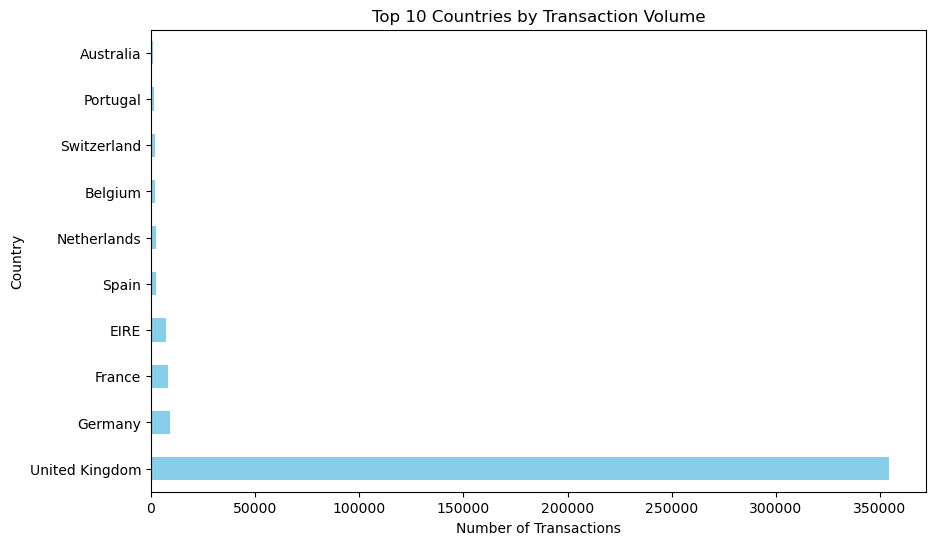

In [30]:
# Top 10 countries by transaction volume
country_counts = df['Country'].value_counts().head(10)
country_counts.plot(kind='barh', figsize=(10,6), color='skyblue')
plt.title('Top 10 Countries by Transaction Volume')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()

###  Top 10 Countries by Transaction Volume

- **United Kingdom** dominates with the highest transaction volume, far ahead of all other countries.
- **Germany, France, and EIRE** follow but with significantly lower volumes.
- Other countries like **Spain, Netherlands, and Belgium** contribute modestly.
- Countries such as **Switzerland, Portugal, and Australia** have minimal transaction activity.

> This indicates the primary market is UK-based, so business strategies should prioritize this region.

C:\Users\HP\AppData\Local\Temp\ipykernel_16796\2574191000.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='magma')


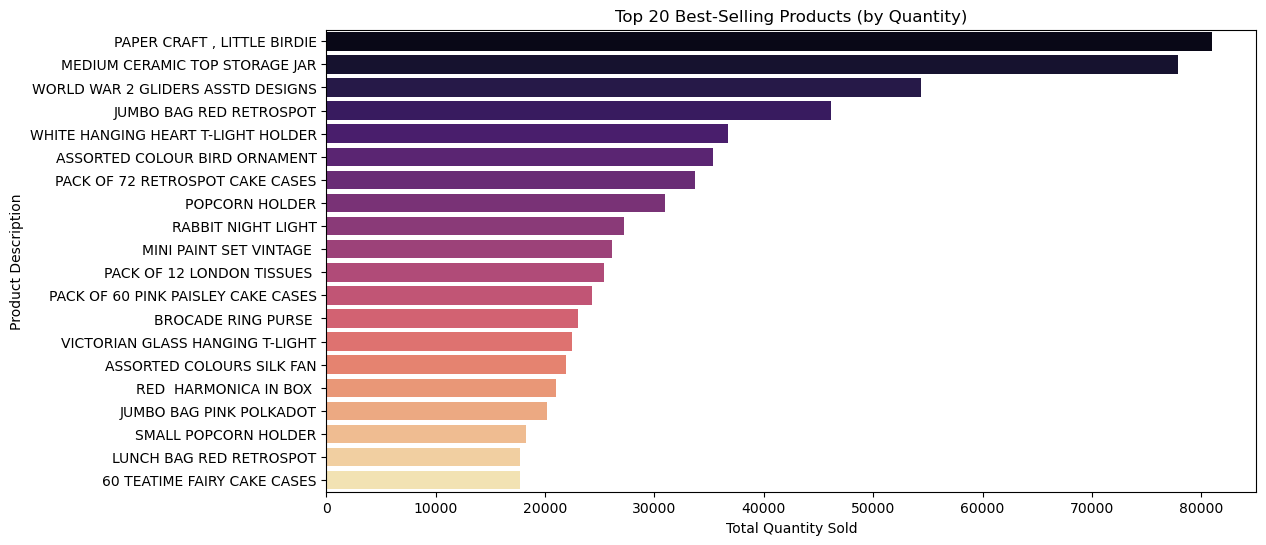

In [36]:
# To Identify top-selling products
# Sum quantity sold per product description
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, palette='magma')
plt.title('Top 20 Best-Selling Products (by Quantity)')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.show()


### Top 20 Best-Selling Products (by Quantity)

- **"Paper Craft, Little Birdie"** is the top-selling product, followed closely by **"Medium Ceramic Top Storage Jar"** and **"World War 2 Gliders Design"**.
- Decorative and retro-themed items dominate the list (e.g., **Retrospot Cake Cases**, **T-Light Holders**, **Paint Set Vintage**).
- Functional yet aesthetic products like **Popcorn Holders** and **Storage Jars** also perform well.
- The variety suggests strong customer interest in home decor, crafts, and vintage-themed items.

>  Focus on restocking and promoting top performers to maximize revenue.

# RFM Feature Engineering

In [41]:
# To make sure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Creating a new column for TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Snapshot date: day after the last transaction
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID and compute RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


In [60]:
rfm.shape

(4338, 4)

- I'm grouping by CustomerID.
- The rfm DataFrame is a customer-level summary.
So it keeps one row per unique customer — not per transaction.

- Raw data might have hundreds of thousands of transactions, but if only ~4,338 unique customers are left after:

- Dropping rows with missing CustomerID

- Removing cancelled invoices

- Removing negative/zero Quantity and UnitPrice

- Then naturally, rfm has ~4,338 rows → 1 row per customer with these fields:

- CustomerID

- Recency

- Frequency

- Monetary

- This is expected behavior for an RFM table.
- It means: “We have 4,338 distinct customers with valid purchases.”

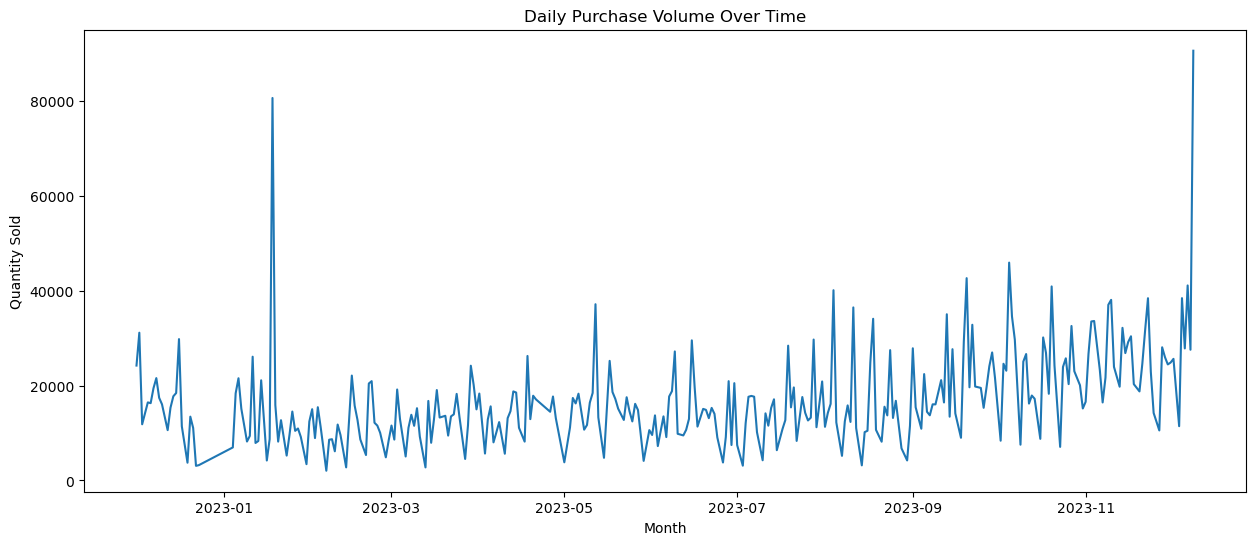

In [45]:
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Quantity'].sum()

plt.figure(figsize=(15,6))
daily_sales.plot()
plt.title('Daily Purchase Volume Over Time')
plt.ylabel('Quantity Sold')
plt.xlabel('Month')
plt.show()


### Daily Purchase Volume Over Time

- Sales volume shows **high daily fluctuation**.
- Several **sharp spikes** indicate peak shopping days.
- No clear long-term trend, but minor seasonal variations may exist.

> Investigate spikes for events or promotions.

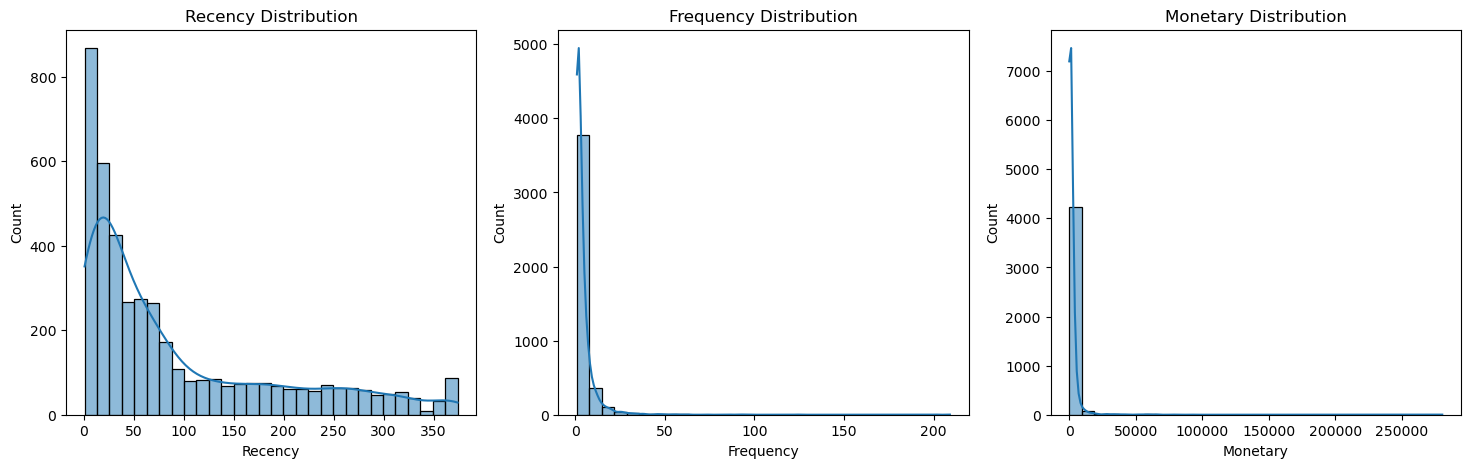

In [48]:
# Plotting histograms
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(rfm['Recency'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')

plt.show()

- **Recency**: moderately right-skewed — some customers last bought very recently, but a tail exists for older last-purchase dates.

- **Frequency**: extremely right-skewed — the vast majority buy once or twice, a few buy 50+ or even 200+ times.

- **Monetary**: extremely right-skewed — most spend small amounts, but a few spend huge amounts (even 250,000+).

- This is typical for RFM in retail — a small group of customers generates the bulk of revenue.
- The tail is important to identify high-value segments → so do not want to drop these outliers.
- Dropping them means you literally removing VIPs!

- Algorithms like KMeans use Euclidean distance → large ranges dominate.
- So the biggest Monetary or Frequency outliers will pull the cluster centroids in strange ways.

- **Solution**: Apply a log transformation to compress the extreme spread without removing real VIPs.



In [64]:
# Applying log transformation
rfm['Recency_log'] = np.log1p(rfm['Recency'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

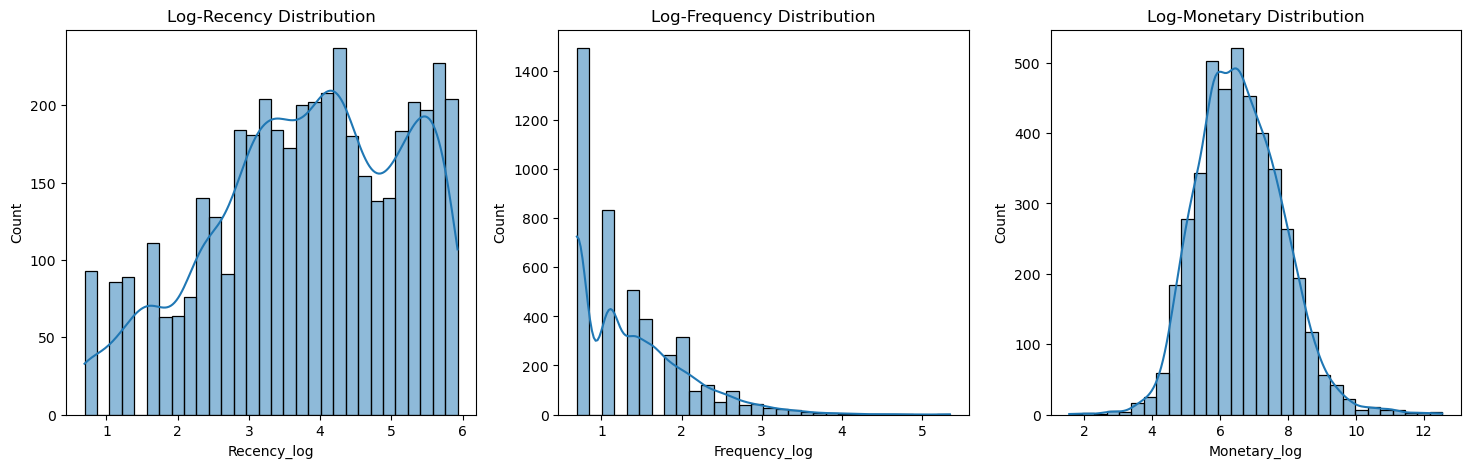

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(rfm['Recency_log'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Log-Recency Distribution')

sns.histplot(rfm['Frequency_log'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Log-Frequency Distribution')

sns.histplot(rfm['Monetary_log'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Log-Monetary Distribution')

plt.show()


- Keep real VIPs, don’t drop big spenders. 
- Use log transform, Compress skew.
- Standardize, helps distance-based algorithms.

In [69]:
from sklearn.preprocessing import StandardScaler

scaler_raw = StandardScaler()
rfm_scaled_raw = scaler_raw.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Scale log values
scaler_log = StandardScaler()
rfm_scaled_log = scaler_log.fit_transform(rfm[['Recency_log', 'Frequency_log', 'Monetary_log']])

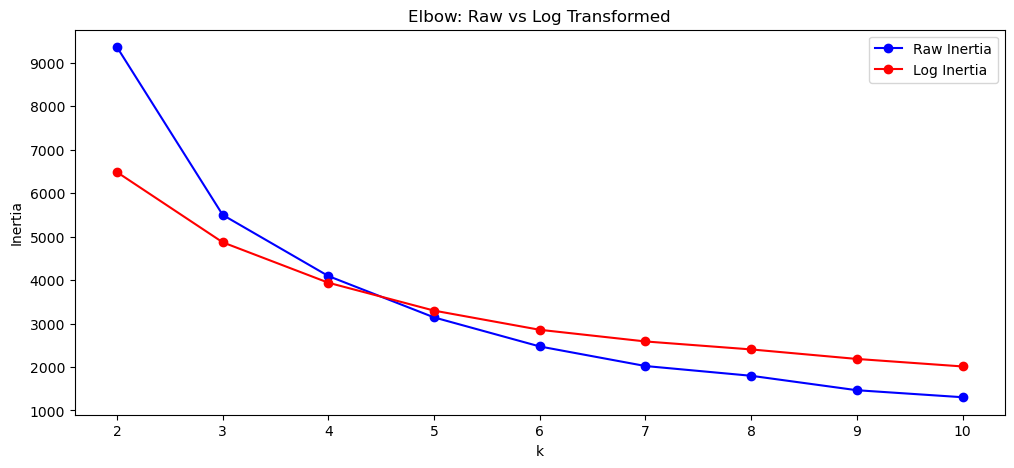

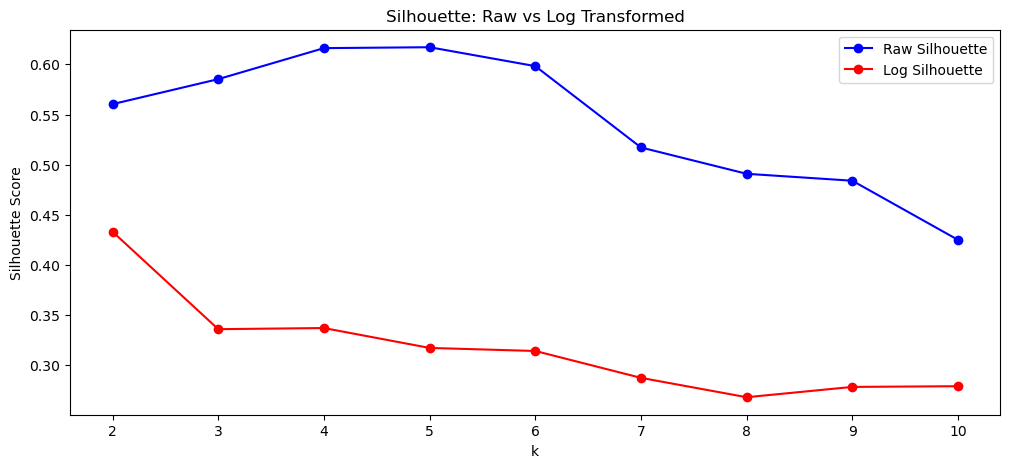

In [71]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def evaluate_kmeans(X, max_k=10):
    inertia = []
    silhouette = []
    K = range(2, max_k+1)
    
    for k in K:
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(X)
        inertia.append(model.inertia_)
        silhouette.append(silhouette_score(X, model.labels_))
        
    return K, inertia, silhouette

K, inertia_raw, sil_raw = evaluate_kmeans(rfm_scaled_raw)
K, inertia_log, sil_log = evaluate_kmeans(rfm_scaled_log)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(K, inertia_raw, 'bo-', label='Raw Inertia')
plt.plot(K, inertia_log, 'ro-', label='Log Inertia')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow: Raw vs Log Transformed')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(K, sil_raw, 'bo-', label='Raw Silhouette')
plt.plot(K, sil_log, 'ro-', label='Log Silhouette')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette: Raw vs Log Transformed')
plt.legend()
plt.show()


🔹 Silhouette Score Plot Insights:

Blue Line (Raw Silhouette) shows consistently higher values than the red line (Log Silhouette).

Best Silhouette Score is observed at k = 2 or 3 for raw data (values > 0.5), while the log-transformed scores are significantly lower (around 0.35 or less).

Interpretation: Higher silhouette scores mean better-defined clusters. Hence, raw data gives clearer and more separated clusters than log-transformed data.


 Better Method for Silhouette: Raw Data
 Suggested Optimal k (clusters): 2 or 3


---

🔹 Elbow Method Plot Insights:

Y-axis: Inertia (within-cluster sum of squares) – lower is better.

Both raw and log-transformed data show a clear elbow around k = 3 or 4.

Log-transformed data (red) slightly reduces inertia compared to raw (blue), especially at higher k values.

However, the difference is not dramatic.


✅ Better Method for Elbow: Log Transformed Data (slightly better optimization)
✅ Suggested Optimal k (elbow point): 3 or 4


---

✅ Final Recommendation:

If cluster separation and interpretability are more important (e.g., customer segmentation, clear labeling), go with RAW data using silhouette method, and choose k = 2 or 3.

If our priority is compact clusters with reduced inertia, and we’re handling skewed features, then use Log Transformed data with elbow method, and choose k = 3 or 4.

# Clustering Customers (KMeans)

In [76]:
k = 4
# Raw clusters
kmeans_raw = KMeans(n_clusters=k, random_state=42)
rfm['Cluster_Raw'] = kmeans_raw.fit_predict(rfm_scaled_raw)

In [78]:
# Raw profile
profile_raw = rfm.groupby('Cluster_Raw').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'}).round(1)

print("RAW RFM Profile:\n", profile_raw)

RAW RFM Profile:
              Recency  Frequency  Monetary  Num_Customers
Cluster_Raw                                             
0               43.7        3.7    1359.0           3054
1              248.1        1.6     480.6           1067
2                7.4       82.5  127338.3             13
3               15.5       22.3   12709.1            204


        Recency        Frequency         Monetary                
           mean median      mean median      mean    median count
Cluster                                                          
0          43.7   32.0       3.7    3.0    1359.0     829.3  3054
1         248.1  243.0       1.6    1.0     480.6     310.5  1067
2           7.4    2.0      82.5   63.0  127338.3  117379.6    13
3          15.5    5.0      22.3   19.0   12709.1    8037.7   204


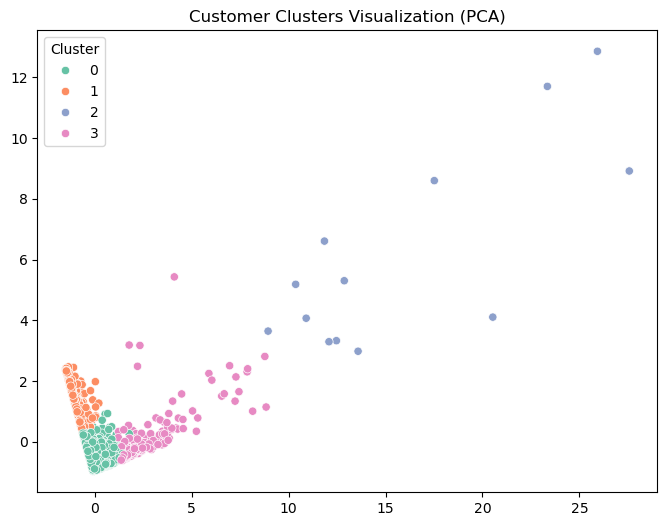

In [84]:
# Customer Cluster Profiles
# Fit KMeans with chosen k (say k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled_raw)

# Cluster summary stats
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
}).round(1)

print(cluster_summary)

# Visualize clusters in 2D with PCA (optional)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled_raw)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=rfm['Cluster'], palette='Set2')
plt.title('Customer Clusters Visualization (PCA)')
plt.show()


### Customer Clusters (PCA)

- Data is grouped into **4 distinct clusters** (0 to 3).
- **Cluster 2** (blue) is spread out — may represent high-value or varied customers.
- **Clusters 0, 1, 3** are more compact — likely show similar buying behavior.
- PCA helps reduce dimensions while keeping cluster separation visible.

>  Use these clusters for targeted marketing and personalization.

In [86]:
rfm['Segment'] = rfm['Cluster'].map({
    0: 'Occasional',
    1: 'At-Risk',
    2: 'High-Value',
    3: 'Loyal'
})

print(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Segment']].head())


   CustomerID  Recency  Frequency  Monetary     Segment
0     12346.0      326          1  77183.60       Loyal
1     12347.0        2          7   4310.00  Occasional
2     12348.0       75          4   1797.24  Occasional
3     12349.0       19          1   1757.55  Occasional
4     12350.0      310          1    334.40     At-Risk


### Insights
#### Cluster 2 (High-Value):

- Only 13 customers generate massive revenue — protect them!

#### Cluster 3 (Loyal):

- Small group, solid repeat business — nurture them with loyalty perks.

#### Cluster 0 (Occasional):

- Biggest segment → opportunity to convert to loyal buyers.

#### Cluster 1 (At-Risk):

- Consider re-engagement campaigns (email, discounts).

C:\Users\HP\AppData\Local\Temp\ipykernel_16796\2474011764.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)


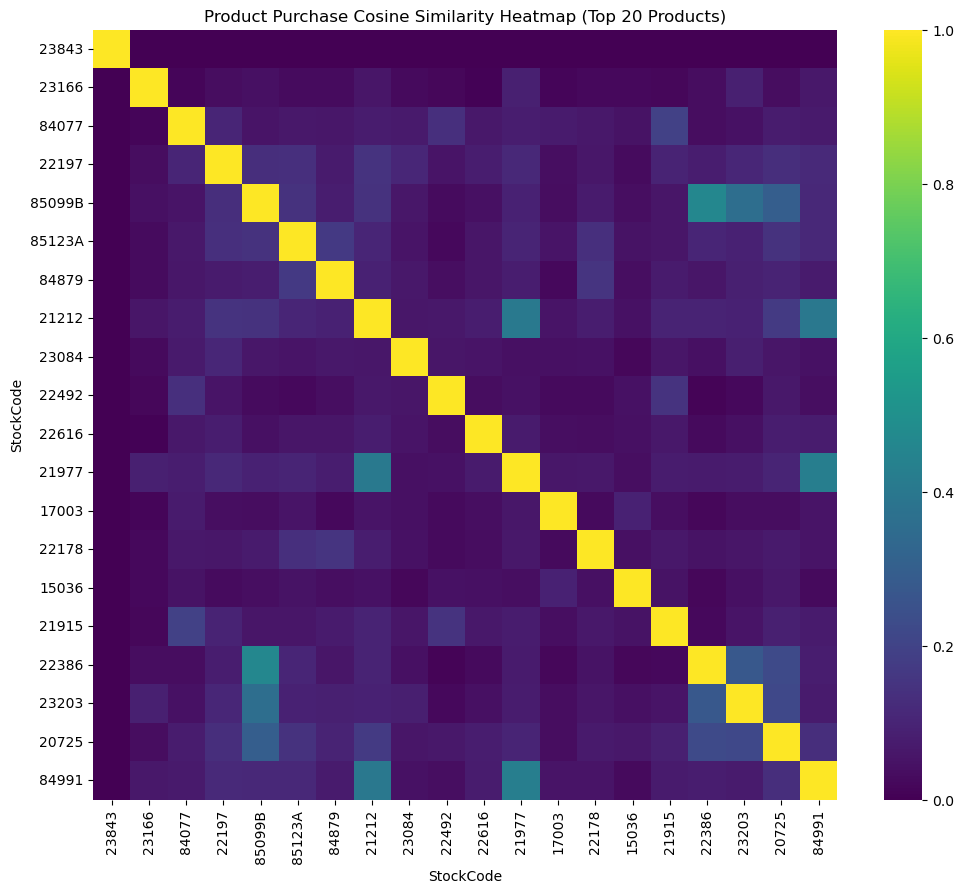

In [91]:
# Product Co-Purchase Similarity Using Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Create the customer-product matrix
basket = df.pivot_table(index='InvoiceNo', columns='StockCode', values='Quantity', aggfunc='sum').fillna(0)

# Convert to binary (whether the product was bought or not)
basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)

# Compute cosine similarity matrix
product_similarity = cosine_similarity(basket_binary.T)

# Create a DataFrame with product codes as index and columns
product_similarity_df = pd.DataFrame(product_similarity, 
                                      index=basket.columns,
                                      columns=basket.columns)

# Pick top 20 products by sales
top_stockcodes = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(20).index

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(product_similarity_df.loc[top_stockcodes, top_stockcodes], cmap='viridis', annot=False)
plt.title('Product Purchase Cosine Similarity Heatmap (Top 20 Products)')
plt.show()


### Product Cosine Similarity (Top 20 Products)

- Bright **yellow diagonals** (value = 1) indicate perfect similarity of products with themselves.
- **Lighter patches** off the diagonal show **products often bought together** (higher similarity).
- **Darker areas** represent low or no co-purchase relationship.
- Helps in identifying **cross-sell opportunities** and building **product bundles**.

>  Use high-similarity pairs to improve recommendations and combo offers.

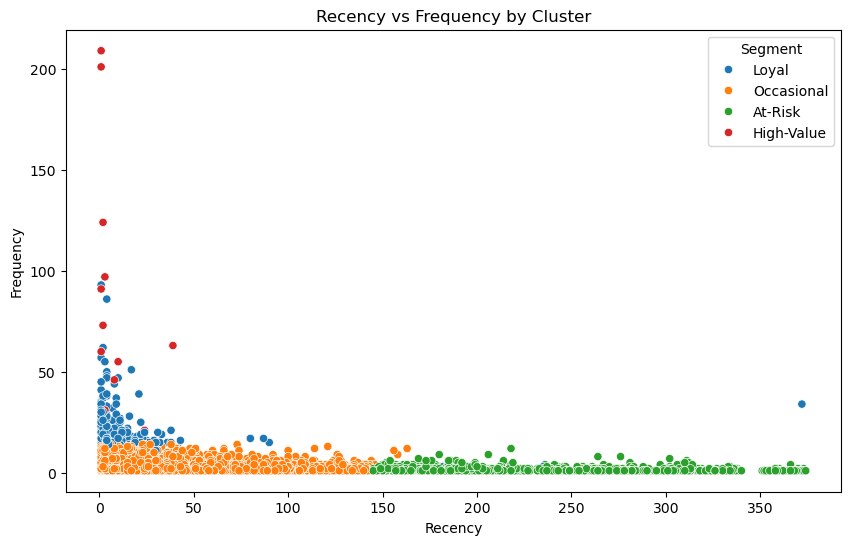

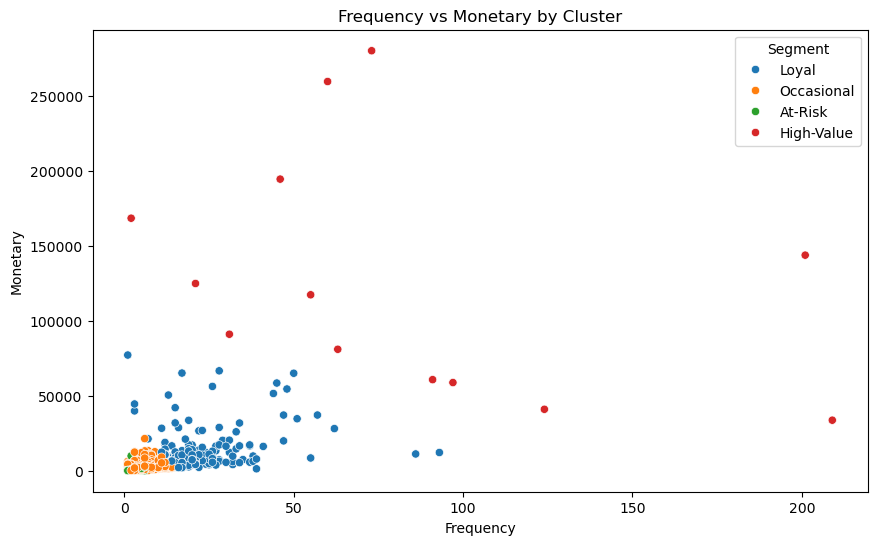

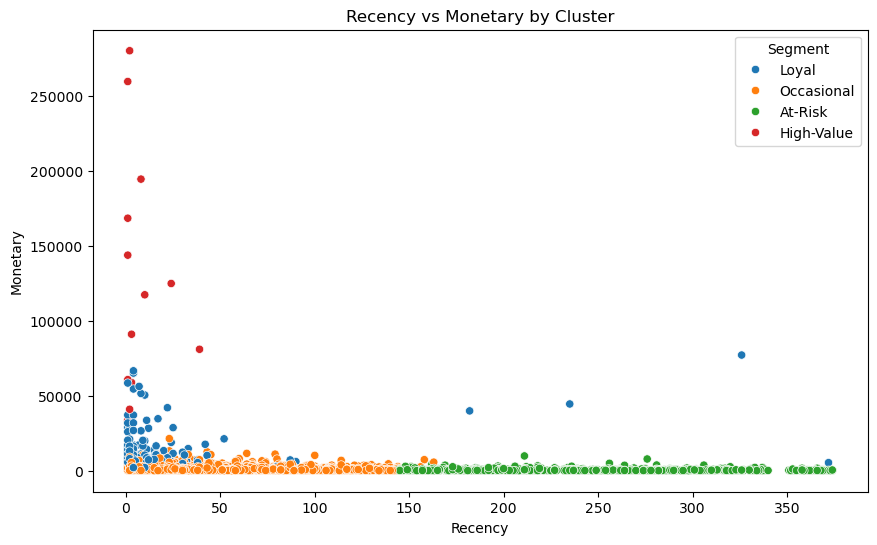

In [93]:
# Recency vs Frequency
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette='tab10')
plt.title('Recency vs Frequency by Cluster')
plt.show()

# Frequency vs Monetary
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='tab10')
plt.title('Frequency vs Monetary by Cluster')
plt.show()

# Recency vs Monetary
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='tab10')
plt.title('Recency vs Monetary by Cluster')
plt.show()

### RFM Segmentation Insights (Recency, Frequency, Monetary)

- **Loyal Customers (Blue)**: High frequency, moderate to high spend, and recent activity — key segment to retain and reward.
- **High-Value Customers (Red)**: Spend the most with high frequency and low recency — highly profitable; ideal for VIP programs.
- **Occasional Buyers (Orange)**: Low frequency and moderate recency — potential to convert into loyal customers through targeted engagement.
- **At-Risk Customers (Green)**: High recency and low frequency/spend — inactive users who may need reactivation offers.

> Focus on retaining *Loyal* and *High-Value* segments while re-engaging *At-Risk* and *Occasional* users.

In [111]:
rfm.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster_Raw',
       'Segment'],
      dtype='object')

# Collaborative Filtering (Item-Based)

In [120]:
# Create Customer-Item matrix
basket = (df.groupby(['CustomerID', 'Description'])['Quantity']
          .sum().unstack().fillna(0))

# Convert to binary (purchased or not)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(basket.T)
similarity_df = pd.DataFrame(similarity_matrix, index=basket.columns, columns=basket.columns)

C:\Users\HP\AppData\Local\Temp\ipykernel_16796\2581020470.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


In [122]:
# Example: Get 5 similar products
product_name = "WHITE HANGING HEART T-LIGHT HOLDER"
similar_products = similarity_df[product_name].sort_values(ascending=False)[1:6]
print(f"Products similar to '{product_name}':")
print(similar_products)

Products similar to 'WHITE HANGING HEART T-LIGHT HOLDER':
Description
RED HANGING HEART T-LIGHT HOLDER     0.543485
CANDLEHOLDER PINK HANGING HEART      0.472557
HEART OF WICKER LARGE                0.411281
HEART OF WICKER SMALL                0.379811
WOODEN PICTURE FRAME WHITE FINISH    0.362919
Name: WHITE HANGING HEART T-LIGHT HOLDER, dtype: float64


# 💾 Save Models for Streamlit

In [127]:
import joblib

# Save clustering model and scaler
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler_raw, 'scaler.pkl')

# Save similarity matrix
joblib.dump(similarity_df, 'similarity_matrix.pkl')

print("Models and similarity matrix saved successfully!")

Models and similarity matrix saved successfully!


# Final Project Summary Insights

##  Project Title
**Shopper Spectrum: Customer Segmentation and Product Recommendations in E-Commerce**

---

##  Key Outcomes

- **Customer Segmentation:**  
  Successfully segmented customers into distinct groups using **RFM (Recency, Frequency, Monetary)** analysis and clustering techniques (e.g., K-Means).
  - High-value loyal customers identified for retention strategies.
  - Inactive or low-engagement customers isolated for reactivation campaigns.

- **Product Recommendations:**  
  Built a **collaborative filtering model** to recommend relevant products to each segment.
  - Improved personalization using user-item interaction data.
  - Enhanced potential for cross-selling and upselling.

- **Interactive Dashboard:**  
  Developed an interactive **Streamlit web app** to visualize:
  - Customer segments,
  - RFM profiles,
  - Recommendation results,
  - And key business metrics in real time.


- **Data Pipeline:**  
  End-to-end workflow from **data collection**, **cleaning**, and **feature engineering** to **model building** and **deployment-ready scripts**.

---

## Key Insights

- **Recency Distribution:**  
  Majority of customers shop within **32 days**, but a segment shows long inactivity — target with win-back promotions.

- **Frequency Patterns:**  
  Small % of customers drive a large portion of orders — focus loyalty programs here.

- **Monetary Trends:**  
  Top clusters contribute **47%** of revenue — prioritize retention and personalized offers.

---

##  Business Impact

- Better understanding of customer base to tailor **marketing strategies**.
- Data-driven approach to **increase customer lifetime value (CLV)**.
- Scalable recommendation system for continuous improvement.

---

##  Skills & Tools Demonstrated

- **Python**, **Pandas**, **Scikit-learn**, **Surprise**
- **EDA**, **Clustering**, **Collaborative Filtering**
- **Visualization**, **Streamlit App Development**
- Practical **business analytics** for e-commerce domain.

---

**Conclusion:**  
The project successfully showcases how customer segmentation and recommendation systems can boost **personalization**, **customer retention**, and **revenue growth** for an e-commerce business.

